###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, C.D. Cooper, G.F. Forsyth.  Based on [CFDPython](https://github.com/barbagroup/CFDPython), (c)2013 L.A. Barba, also under CC-BY license.

# Relax and hold steady

You've reached the fifth module of the open course [**"Practical Numerical Methods with Python"**](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about), titled *Relax and hold steady: elliptic problems*. We hope that you are enjoying the ride of [#numericalmooc](https://twitter.com/hashtag/numericalmooc) so far!

We introduced finite-difference methods for partial differential equations (PDEs) in the [second module](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/tree/master/lessons/02_spacetime/), and looked at convection problems in more depth in [module 3](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/tree/master/lessons/03_wave/). 

In [module 4](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/tree/master/lessons/04_spreadout/) we explored diffusion-dominated problems.  It's been quite a trip so far and now it's time to stop worrying about **time** and relax.  

## Laplace's Equation

Here is Laplace's equation in 2D:

\begin{equation}
\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = 0
\end{equation}

See anything familiar?  What should jump out at you right away is the *strong* similarity to the diffusion equation that was the focus of [module 4](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/tree/master/lessons/04_spreadout/), but what's different?

The Laplace Equation does not have a time dependence — there is no $p^{n+1}$.  Instead of tracking a wave through time as in previous modules, the Laplace equation calculates the equilibrium state of a system under the supplied boundary conditions.  

If you have taken coursework in Heat Transfer, you will recognize the Laplace Equation as the steady-state heat equation.

Laplace's equation has the features typical of diffusion phenomena. For this reason, it has to be discretized with *central differences*, so that the discretization is consistent with the physics we want to simulate. 

You should be able to write out a second-order central difference scheme by now.  

\begin{equation}
\frac{p_{i+1, j}^n - 2p_{i,j}^n + p_{i-1,j}^n}{\Delta x^2} + \frac{p_{i,j+1}^n - 2p_{i,j}^n + p_{i, j-1}^n}{\Delta y^2} = 0
\end{equation}

We can rearrange this equation and solve for $p_{i,j}^{n}$ to get

\begin{equation}
p_{i,j}^{n} = \frac{\Delta y^2(p_{i+1,j}^n+p_{i-1,j}^n)+\Delta x^2(p_{i,j+1}^n + p_{i,j-1}^n)}{2(\Delta x^2 + \Delta y^2)}
\end{equation}

Since there is no time dependence in the Laplace Equation, instead of calculating where the system will be at some time $t$, we will iteratively solve for $p_{i,j}^{n}$ until it meets a condition that we specify.  The system will reach equilibrium only as the number of iterations tends to $\infty$, but we can approximate the equilibrium state by iterating until the change between one iteration and the next is *very* small.  

This method of iterative solution is known as the **Jacobi method**.

Using second-order central-difference schemes in both directions is the most widely applied method for the Laplace operator. It is also known as the **five-point difference operator**, alluding to its stencil.

<br>

<img src="./figures/laplace.svg">

#### Figure 1: Laplace five-point stencil

Very often we deal with meshes where $\Delta x = \Delta y$ and we can use this to further simplify Equation $(3)$.  

If $\Delta x = \Delta y$, Equation $(3)$ becomes

\begin{equation}
p^{n}_{i,j} = \frac{1}{4} \left(p^{n}_{i,j-1} + p^n_{i,j+1} + p^{n}_{i-1,j} + p^n_{i+1,j} \right)
\end{equation}


### Boundary conditions

We are going to solve Laplace's equation numerically by assuming an initial state of $p=0$ everywhere and then add the following boundary conditions:

\begin{equation}
  \begin{gathered}
p=0 \text{ at } x=0\\
\frac{\partial p}{\partial x} = 0 \text{ at } x = L\\
p = 0 \text{ at }y = 0 \\
p = \sin \left(  \frac{\frac{3}{2}\pi x}{L} \right) \text{ at } y = H
  \end{gathered}
\end{equation}


Where $L=1$ and $H=1$ are the sizes of the domain in the $x$ and $y$ directions, respectively.

One of the defining features of elliptic PDEs is that they are "driven" by the boundary conditions.  The boundaries are set to specific values and the solution relaxes to join the boundaries together.  

First let's import our usual smattering of libraries (plus a few new ones!)

In [1]:
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

When we want to visualize 2D data, we can often use `pyplot.imshow` as we did in the Reaction-Diffusion assignment, but often a 3D projection plot can provide a more intuitive view of a system.  

For projection plots, we have to import the `Axes3D` library from matplotlib.  We'll also grab the `cm` package, which provides different colormaps for visualizing plots.  

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

Rather than repeatedly setting up a 3D plotting environment to visualize each result, we can define a function to save time later.  

Many examples of 3D projection plots are available in the mplot3d section of the [matplotlib gallery](http://matplotlib.org/gallery.html#mplot3d).  

In [3]:
def plot2D(x, y, p):
    '''Creates 3D projection plot with appropriate limits and viewing angle
    
    Parameters:
    ----------
    x: array of float
        nodal coordinates in x
    y: array of float
        nodal coordinates in y
    p: 2D array of float
        calculated potential field
    
    '''
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,p[:], rstride=1, cstride=1, cmap=cm.PuOr,
            linewidth=0, antialiased=False)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.view_init(30,45)


### Analytical Solution

The Laplace equation with the boundary conditions listed in $(4)$ have an analytical solution, given by

\begin{equation}
p(x,y) = \frac{\sinh \left( \frac{\frac{3}{2} \pi y}{L}\right)}{\sinh \left(  \frac{\frac{3}{2} \pi H}{L}\right)} \sin \left( \frac{\frac{3}{2} \pi x}{L} \right)
\end{equation}

where $L$ and $H$ are the length of the domain in the $x$ and $y$ directions, respectively.

We used `numpy.meshgrid` to plot our 2D solutions to the heat equation in Module 4.  Here we again use it as a plotting aid.  `linspace` creates 1-row arrays which work well for defining $x$ and $y$ axes in line plots, but now we want the analytical solution at every point in our domain.  To do this, we create a meshgrid and then use the X and Y values from `numpy.meshgrid` in the analytical solution.

In [4]:
def p_analytical(x, y):
    X, Y = numpy.meshgrid(x,y)
    
    p_an = numpy.sinh(1.5*numpy.pi*Y / x[-1]) /\
    (numpy.sinh(1.5*numpy.pi*y[-1]/x[-1]))*numpy.sin(1.5*numpy.pi*X/x[-1])
    
    return p_an

Ok, let's try out the analytical solution and use it to test the `plot2D` function we wrote above.  

In [5]:
nx = 41
ny = 41

x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

p_an = p_analytical(x,y)

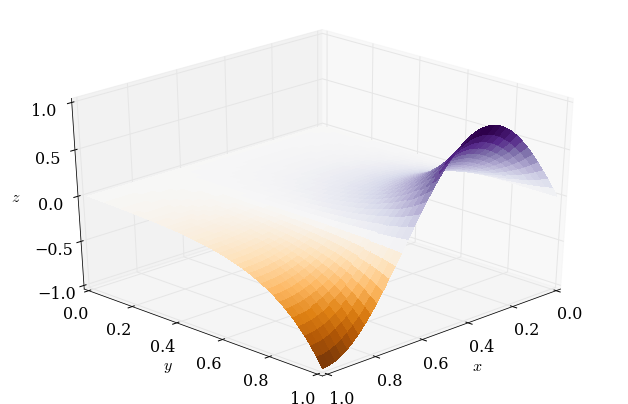

In [6]:
plot2D(x,y,p_an)

It worked!  This is what the solution *should* look like when we're 'done' relaxing.  

### How long do we iterate?

We noted above that there is no time dependence in the Laplace equation.  Given that, using a `for` loop with `nt` iterations doesn't make a lot of sense.  

Instead we can use a `while` loop that continues to iteratively solve for the solution until the difference between two successive iterations is small enough.  

How small is small enough?  That's a good question.  We'll try to work that out as we go along.  

How can we best compare two successive potential fields?  The [L2 norm][1] is a good option.  It's defined as

\begin{equation}
|\textbf{x}| = \sqrt{\sum_{i=0}^n |x_i|^2}
\end{equation}

There's one serious flaw with this.  We are effectively summing the difference at each point in our grid between successive iterations -- but what happens when the grid grows?  There are more points, in total, to compare and so more possible sources of error between the two solutions.  

That doesn't seem fair, does it?  We can normalize the error by further dividing our existing L2 norm by the sum of the potential field.  

For two successive iterations, the L2 norm is then calculated as

\begin{equation}
|\textbf{x}| = \frac{\sqrt{\sum_{i=0, j=0}^n |p^{n+1}_{i,j} - p^n_{i,j}|^2}}{\sqrt{\sum_{i=0, j=0}^n |p^n_{i,j}|^2}}
\end{equation}

The normalized `L2_error` function, then, will be

[1]:http://en.wikipedia.org/wiki/Norm_%28mathematics%29#Euclidean_norm

In [7]:
def L2_error(p, pn):
    return numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))

Now, let's define a function that will do the iterations for us.  Three of the boundaries are Dirichlet boundaries and so we can simply leave them alone.  Only the Neumann boundary needs to be explicitly calculated at each iteration.  

In [8]:
def laplace2d(p, y, dx, dy, l2_target):
    '''Solves the diffusion equation with forward-time, centered scheme
    
    Parameters:
    ----------
    p: 2D array of float
        Initial potential distribution
    y: array of float
        Nodal coordinates in y
    dx: float
        Mesh size
    dy: float
        Mesh size
    l2_target: float
        Error target
        
    Returns:
    -------
    p: 2D array of float
        Potential distribution after relaxation
    '''
    
    l2norm = 1
    pn = numpy.empty_like(p)
    iterations = 0
    while l2norm > l2_target:
        pn = p.copy()
        p[1:-1,1:-1] = .25 * (pn[1:-1,2:] + pn[1:-1, :-2] \
                              + pn[2:, 1:-1] + pn[:-2, 1:-1])
        
        ##Neumann B.C. along x = L
        p[1:-1, -1] = p[1:-1, -2]
        l2norm = L2_error(p, pn)
     
    return p

### Initial conditions

The problem states that our domain is set to zero everywhere as an initial "guess" except for 

$$p = \sin \left(  \frac{\frac{3}{2}\pi x}{L} \right) \text{ at } y=H$$

To define the domain, `numpy.zeros` will handle everything except that one Dirichlet condition.

In [9]:
##variable declarations
nx = 41
ny = 41
dx = 1/(nx-1)
dy = 1/(ny-1)


##initial conditions
p = numpy.zeros((ny,nx)) ##create a XxY vector of 0's


##plotting aids
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

##Dirichlet boundary conditions
p[-1,:] = numpy.sin(1.5*numpy.pi*x/x[-1])


Now let's visualize the initial conditions using the `plot2D` function.


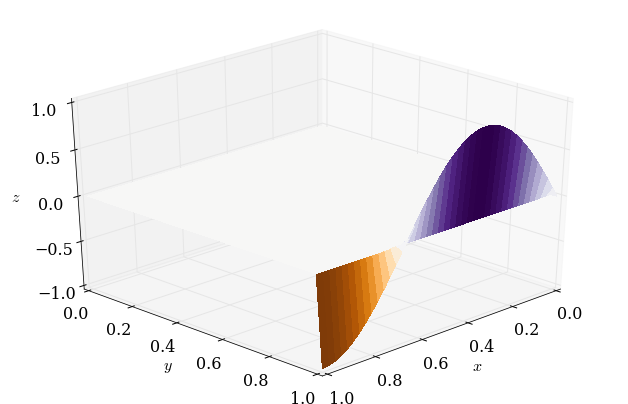

In [10]:
plot2D(x, y, p)

The `p` array is equal to zero everywhere, except along the boundary $y = 1$.  Hopefully you can see how the relaxed solution and this initial condition are related.  

Now run the iterative solver with a target L2 difference of $1\tt{E}$$^-8$

In [11]:
p = laplace2d(p.copy(), y, dx, dy,1e-8)

Now try plotting this new value of `p` with the newly minted `plot2D` function.

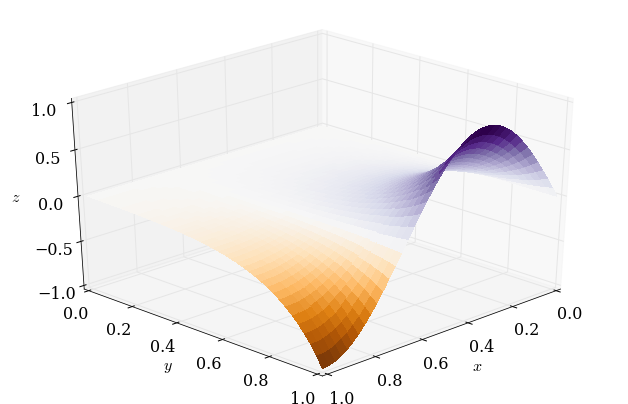

In [12]:
plot2D(x,y,p)

Awesome!  That looks pretty good!  We'll need more than a simple visual check, though.

## Relaxation & Convergence

We're also going to write a function to "reset" the initial conditions for a given value of `nx` so we don't have to keep copying and pasting them.  

In [13]:
def laplace_IC(nx):
    '''Generates initial conditions for Laplace 2D problem for a 
    given number of grid points (nx) within the domain [0,1]x[0,1]
    
    Parameters:
    ----------
    nx: int
        number of grid points in x (and implicitly y) direction
        
    Returns:
    -------
    p: 2D array of float
        Pressure distribution after relaxation
    x: array of float
        linspace coordinates in x
    y: array of float
        linspace coordinates in y
    dx: float
        grid spacing in x
    dy: float
        grid spacing in y
    '''
    dx = 1/(nx-1)

    ##initial conditions
    p = numpy.zeros((nx,nx)) ##create a XxY vector of 0's

    ##plotting aids
    x = numpy.linspace(0,1,nx)
    y = x
    dy = dx

    ##Dirichlet boundary conditions
    p[:,0] = 0
    p[0,:] = 0
    p[-1,:] = numpy.sin(1.5*numpy.pi*x/x[-1])
    
    return p, x, y, dx, dy

### Convergence Analysis

We want to make sure that our Jacobi function is working properly.  Since we have an analytical solution, what better way than to do a convergence test?  As per usual, we will run our solver for several grid sizes and then check that the rate of decrease of error matches up with the increase in grid size.  

In [14]:
nx_values = [11, 21, 41, 81]
l2_target = 1e-8

error = numpy.empty_like(nx_values, dtype=numpy.float)


for i, nx in enumerate(nx_values):
    p, x, y, dx, dy = laplace_IC(nx)
    
    p = laplace2d(p.copy(), y, dx, dy, l2_target)
    
    p_an = p_analytical(x, y)
    
    error[i] = L2_error(p, p_an)
    

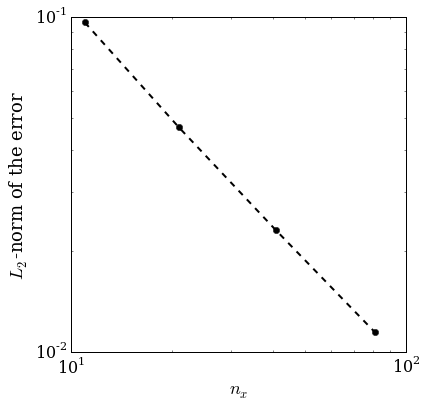

In [15]:
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)

pyplot.loglog(nx_values, error, color='k', ls='--', lw=2, marker='o')
pyplot.axis('equal');

That doesn't look like 2nd-order convergence.  What's going on?  The discretization is 2nd-order and Dirichlet conditions are order-agnostic (a  set value is a set value), but the Neumann boundary condition is 1st-order.  

Remember when we said that the boundaries drive the problem?  One boundary that's 1st-order completely tanked our convergence.  Let's fix it!

### 2nd-order Neumann Boundary Conditions

Up to this point, we have used the first-order approximation of a derivative to satisfy Neumann B.C.'s, e.g.

\begin{equation}
\frac{p^{n}_{1,j} - p^{n}_{0,j}}{\Delta x} = 0
\end{equation}

which, solving for $p^{n}_0$ gives us

\begin{equation}
p^{n}_{0,j} = p^{n}_{1,j}
\end{equation}

Using that Neumann condition will limit us to 1st-order convergence.  Instead, we can start with a 2nd-order approximation (the central-difference approximation):

\begin{equation}
\frac{p^{n}_{1,j} - p^{n}_{-1,j}}{2 \Delta x} = 0
\end{equation}

That seems slightly problematic, since $p^{n}_{-1,j}$ doesn't exist.  But no matter -- according to the 2nd-order approximation,

\begin{equation}
p^{n}_{-1,j} = p^{n}_{1,j}
\end{equation}

Recall the finite-difference Jacobi equation with $i=0$

\begin{equation}
p^{n}_{0,j} = \frac{1}{4} \left(p^{n}_{0,j-1} + p^n_{0,j+1} + p^{n}_{-1,j} + p^n_{1,j} \right)
\end{equation}

Notice that the equation relies on the trouble point $p^n_{-1,j}$, but according to Equation $(9)$, we have a value we can substitute, namely $p^n_{1,j}$, leaving us with the completed 2nd-order Neumann condition

\begin{equation}
p^{n}_{0,j} = \frac{1}{4} \left(p^{n}_{0,j-1} + p^n_{0,j+1} + 2p^{n}_{1,j} \right)
\end{equation}

That's a bit more complicated than the first-order version, but it's relatively straightforward to code.

##### $p^{n}_{-1,j}$ is *NOT* `p[-1]`.  

`p[-1]` is a piece of Python code used to refer to the last element of a list or array named `p`.  $p^{n}_{-1,j}$ is a 'ghost' point that describes a position that lies outside the actual domain.

### Convergence, Take 2

Here we can copy our old Jacobi function and then replace only the Neumann boundary condition line.  

In [16]:
def laplace2d_neumann(p, y, dx, dy, l2_target):
    '''Solves the diffusion equation with forward-time, centered scheme
    
    Parameters:
    ----------
    p: 2D array of float
        Initial potential distribution
    y: array of float
        Nodal coordinates in y
    dx: float
        Mesh size
    dy: float
        Mesh size
    l2_target: float
        Error target
        
    Returns:
    -------
    p: 2D array of float
        Potential distribution after relaxation
    '''
    
    l2norm = 1
    pn = numpy.empty_like(p)
    iterations = 0
    while l2norm > l2_target:
        pn = p.copy()
        p[1:-1,1:-1] = .25 * (pn[1:-1,2:] + pn[1:-1, :-2] \
                              + pn[2:, 1:-1] + pn[:-2, 1:-1])
        
        ##2nd-order Neumann B.C. along x = L
        p[1:-1,-1] = .25 * (2*pn[1:-1,-2] + pn[2:, -1] + pn[:-2, -1])
        
        l2norm = L2_error(p, pn)
     
    return p

Again, this is the exact same code, but now we're calling a Jacobi solver with a 2nd-order Neumann boundary condition.  

In [17]:
nx_values = [11, 21, 41, 81]
l2_target = 1e-8

error = numpy.empty_like(nx_values, dtype=numpy.float)


for i, nx in enumerate(nx_values):
    p, x, y, dx, dy = laplace_IC(nx)
    
    p = laplace2d_neumann(p.copy(), y, dx, dy, l2_target)
    
    p_an = p_analytical(x, y)
    
    error[i] = L2_error(p, p_an)

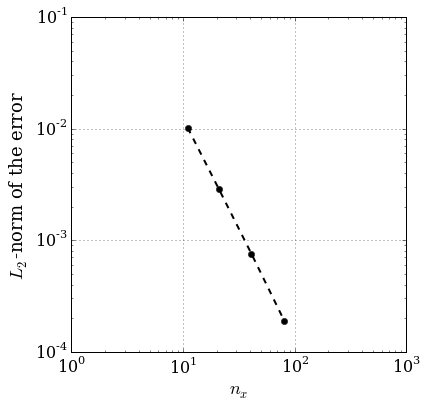

In [18]:
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)

pyplot.loglog(nx_values, error, color='k', ls='--', lw=2, marker='o')
pyplot.axis('equal');

Nice!  That's much better.  It might not be *exactly* 2nd-order, but it's awfully close.  

## Learn More

And for a detailed walk-through of the discretization of Laplace and Poisson equations (steps 9 and 10), watch **Video Lesson 12** on You Tube:

In [19]:
from IPython.display import YouTubeVideo
YouTubeVideo('iwL8ashXhWU')

## References

*  Thomas, James William. Numerical partial differential equations: conservation laws and elliptic equations. Vol. 3. Berlin: Springer, 1999.

*  Thomas, J. W. (1999). Numerical partial differential equations: conservation laws and elliptic equations (Vol. 3). Berlin: Springer.

In [20]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())